In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (update the path as needed)
file_path = "/content/Merged_Disasters(1).csv"
df = pd.read_csv(file_path)

# Perform stratified splitting
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

print("Data split completed and saved as CSV files.")


Data split completed and saved as CSV files.


Train class distribution:
 Binary_class
0    10853
1     1804
Name: count, dtype: int64
Validation class distribution:
 Binary_class
0    2326
1     386
Name: count, dtype: int64
Test class distribution:
 Binary_class
0    2326
1     387
Name: count, dtype: int64
Accuracy: 0.8769
ROC-AUC: 0.7359
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      2326
           1       0.84      0.17      0.28       387

    accuracy                           0.88      2713
   macro avg       0.86      0.58      0.61      2713
weighted avg       0.87      0.88      0.84      2713



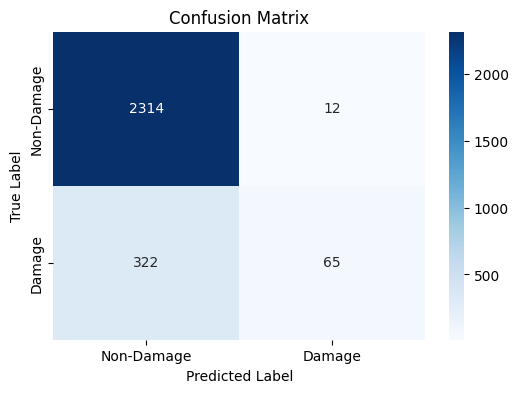

In [3]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Paths to the split data
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

# Load the data
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# Standardize labels
label_map = {'damage': 1, 'non damage': 0}
train_df['Binary_class'] = train_df['Binary_class'].str.strip().str.lower().replace({'non-damage': 'non damage'})
val_df['Binary_class'] = val_df['Binary_class'].str.strip().str.lower().replace({'non-damage': 'non damage'})
test_df['Binary_class'] = test_df['Binary_class'].str.strip().str.lower().replace({'non-damage': 'non damage'})

# Convert labels to numerical format
y_train = train_df['Binary_class'].map(label_map)
y_val = val_df['Binary_class'].map(label_map)
y_test = test_df['Binary_class'].map(label_map)

# Ensure 'tweet_text' exists and handle missing values
train_texts = train_df['tweet_text'].fillna("").apply(lambda x: x.lower().split())
val_texts = val_df['tweet_text'].fillna("").apply(lambda x: x.lower().split())
test_texts = test_df['tweet_text'].fillna("").apply(lambda x: x.lower().split())

# Check class distribution
print("Train class distribution:\n", y_train.value_counts())
print("Validation class distribution:\n", y_val.value_counts())
print("Test class distribution:\n", y_test.value_counts())

# Word2Vec model
w2v_model = Word2Vec(sentences=train_texts, vector_size=100, window=5, min_count=1, workers=4)

# Function to convert text to Word2Vec vectors
def text_to_w2v_vector(text, model, vector_size=100):
    words = [word for word in text if word in model.wv]
    if len(words) == 0:
        return np.zeros(vector_size)
    return np.mean(model.wv[words], axis=0)

# Convert texts to vectors
X_train = np.array([text_to_w2v_vector(text, w2v_model) for text in train_texts])
X_val = np.array([text_to_w2v_vector(text, w2v_model) for text in val_texts])
X_test = np.array([text_to_w2v_vector(text, w2v_model) for text in test_texts])

# Compute class weights only if both classes exist
if len(np.unique(y_train)) == 2:
    class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
else:
    class_weight_dict = None

# Train RandomForest
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print('Classification Report:\n', classification_rep)

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
